# Predictive Information Playground

This notebook explores predictive information (excess entropy) calculations for PFSAs.

Predictive information E = I[X<t : X≥t] measures the mutual information between the past and future of a stochastic process.


In [1]:
from itertools import product
import random
import json
from math import ceil

import numpy as np
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt

np.printoptions(precision=3)

from src.pfsa.fsa_generator import random_dpfsa, random_pfsa, geometric_sum_pfsa, random_ngram
from src.pfsa.fsa import PFSA

In [2]:
# Import the predictive information module
from src.pfsa.predictive_information import (
    calculate_predictive_information,
    calculate_predictive_information_with_convergence,
    plot_entropy_convergence,
    plot_entropy_rate_comparison,
    analyze_predictive_information_across_parameters
)

## Generate a Sample PFSA


In [3]:
# Generate a sample PFSA
A = random_dpfsa(
    4,
    4,
    conditions=[lambda A: 10 < A.mean_length < 80],
    mean_length=20,
    topology_seed=2,
    weight_seed=2,
)

print(f"Generated PFSA with {A.n_states} states and {A.n_symbols} symbols")
print(f"Mean length: {A.mean_length:.2f}")
print(f"Next symbol entropy: {A.next_symbol_entropy:.4f}")

Generated PFSA with 4 states and 4 symbols
Mean length: 20.00
Next symbol entropy: 1.5371


## Calculate Predictive Information


In [4]:
# Calculate predictive information with detailed convergence analysis
E, h_values, h_asymptotic, converged_at = calculate_predictive_information_with_convergence(
    A, max_n=8, tol=1e-5, window=3
)

print(f"Predictive Information E = {E:.4f}")
print(f"Asymptotic entropy rate h = {h_asymptotic:.4f}")
print(f"next_symbol_entropy = {A.next_symbol_entropy:.4f}")
print(f"Are they equal? {np.isclose(h_asymptotic, A.next_symbol_entropy)}")

if converged_at:
    print(f"\nConverged at n = {converged_at}")
else:
    print("\nDid not converge within max_n iterations")

print(f"\nEntropy values (starting from h_2):")
for i, h_n in enumerate(h_values[:10], 2):
    print(f"h_{i} = {h_n:.4f}")

Computing 8-local entropy: 100%|██████████| 16384/16384 [00:00<00:00, 25175.36it/s]

Predictive Information E = 0.3725
Asymptotic entropy rate h = 1.5530
next_symbol_entropy = 1.5371
Are they equal? False

Did not converge within max_n iterations

Entropy values (starting from h_2):
h_2 = 1.7183
h_3 = 1.6448
h_4 = 1.6123
h_5 = 1.5851
h_6 = 1.5709
h_7 = 1.5593
h_8 = 1.5530


In [5]:
# Let's see how the entropy rates converge to next_symbol_entropy
print("Convergence analysis:")
print(f"True asymptotic rate (next_symbol_entropy): {A.next_symbol_entropy:.6f}")
print("\nn  | h_n       | h_n - h_asymptotic")
print("-" * 35)

for i, h_n in enumerate(h_values[:15], 2):
    diff = h_n - A.next_symbol_entropy
    print(f"{i:2} | {h_n:.6f} | {diff:+.6f}")

Convergence analysis:
True asymptotic rate (next_symbol_entropy): 1.537124

n  | h_n       | h_n - h_asymptotic
-----------------------------------
 2 | 1.718272 | +0.181148
 3 | 1.644797 | +0.107673
 4 | 1.612286 | +0.075162
 5 | 1.585120 | +0.047996
 6 | 1.570875 | +0.033751
 7 | 1.559340 | +0.022216
 8 | 1.553038 | +0.015914


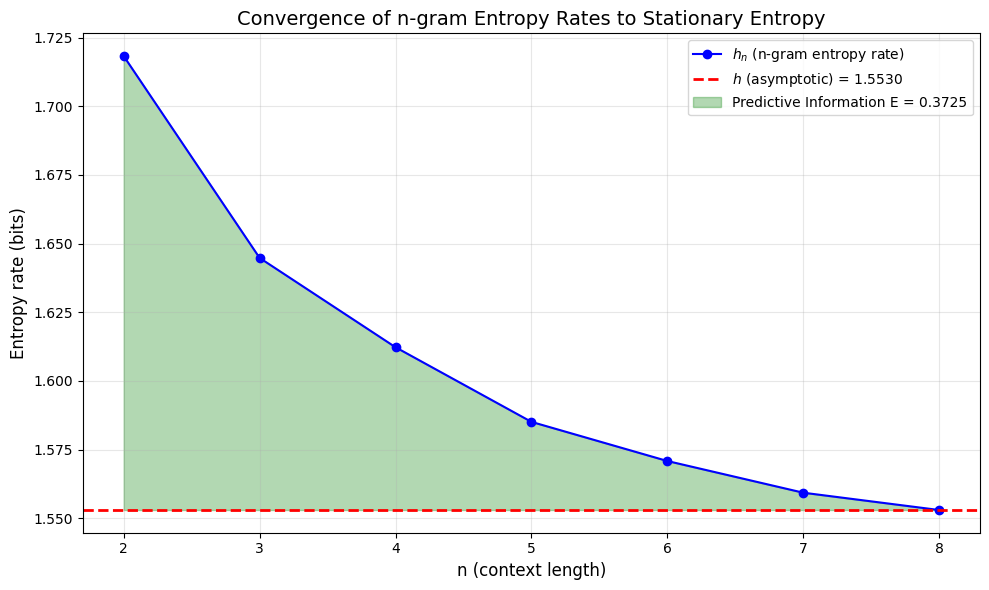

In [6]:
# Visualize the convergence (note: x-axis now starts from n=2)
plot_entropy_convergence(h_values, h_asymptotic, E, converged_at,
                        title="Convergence of n-gram Entropy Rates to Stationary Entropy")

## Compare Multiple PFSAs


Computing 8-local entropy: 100%|██████████| 16384/16384 [00:00<00:00, 27983.54it/s]


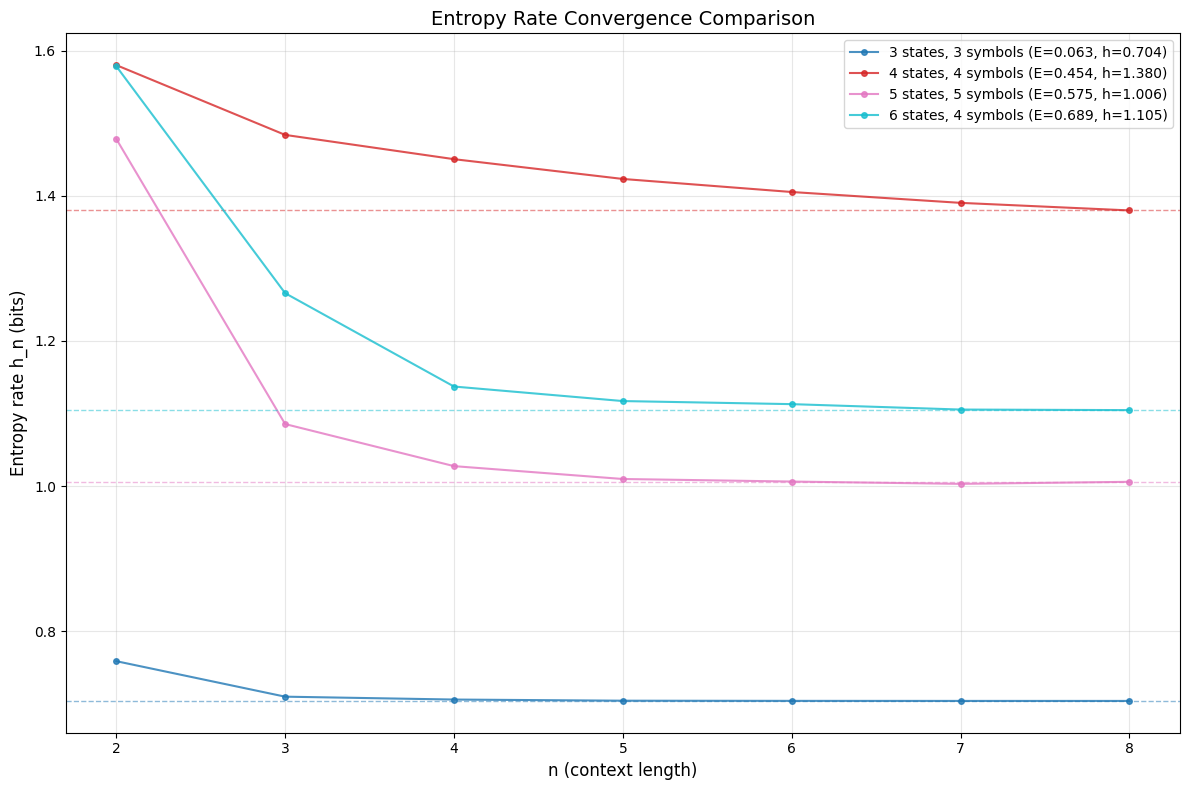

In [7]:
# Let's generate multiple PFSAs and compare their convergence behavior
pfsa_configs = [
    (3, 3, "3 states, 3 symbols"),
    (4, 4, "4 states, 4 symbols"),
    (5, 5, "5 states, 5 symbols"),
    (6, 4, "6 states, 4 symbols"),
]

pfsa_list = []
labels = []

for n_states, n_symbols, label in pfsa_configs:
    pfsa = random_dpfsa(
        n_states,
        n_symbols,
        conditions=[lambda A: 10 < A.mean_length < 30],
        mean_length=20,
        topology_seed=2,
        weight_seed=np.random.randint(0, 10000),
    )
    pfsa_list.append(pfsa)
    labels.append(label)

# Compare their entropy rate convergence
plot_entropy_rate_comparison(pfsa_list, labels, max_n=8)

Computing 8-local entropy: 100%|██████████| 279936/279936 [00:06<00:00, 43343.56it/s]


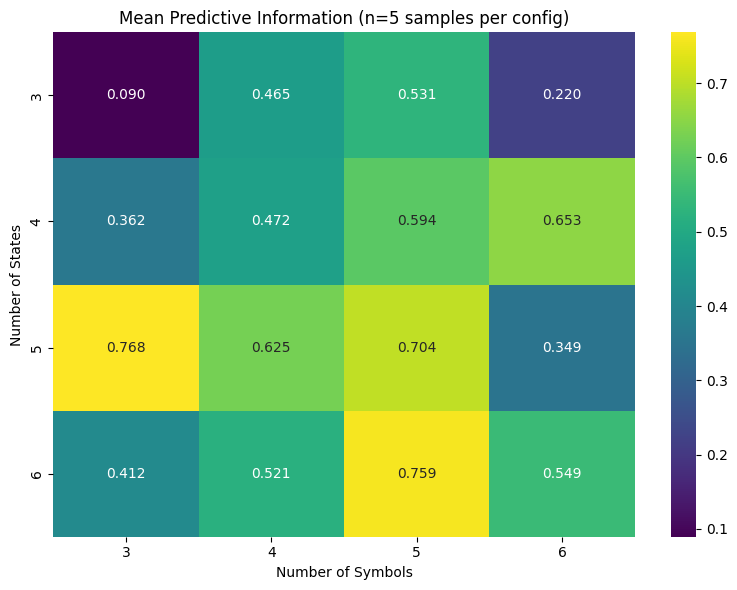


Predictive Information Summary:
States | Symbols | E (mean ± std) | h (mean ± std)
------------------------------------------------------------
     3 |       3 | 0.090 ± 0.036 | 0.957 ± 0.093
     3 |       4 | 0.465 ± 0.131 | 1.116 ± 0.176
     3 |       5 | 0.531 ± 0.130 | 1.522 ± 0.215
     3 |       6 | 0.220 ± 0.231 | 1.570 ± 0.244
     4 |       3 | 0.362 ± 0.159 | 0.965 ± 0.234
     4 |       4 | 0.472 ± 0.190 | 1.408 ± 0.113
     4 |       5 | 0.594 ± 0.113 | 1.428 ± 0.206
     4 |       6 | 0.653 ± 0.054 | 1.460 ± 0.156
     5 |       3 | 0.768 ± 0.193 | 1.102 ± 0.087
     5 |       4 | 0.625 ± 0.205 | 1.115 ± 0.179
     5 |       5 | 0.704 ± 0.019 | 1.186 ± 0.159
     5 |       6 | 0.349 ± 0.437 | 1.315 ± 0.285
     6 |       3 | 0.412 ± 0.110 | 1.066 ± 0.185
     6 |       4 | 0.521 ± 0.239 | 1.096 ± 0.172
     6 |       5 | 0.759 ± 0.298 | 1.239 ± 0.282
     6 |       6 | 0.549 ± 0.131 | 1.254 ± 0.203


In [8]:
# Analyze predictive information across different parameter settings
n_states_list = [3, 4, 5, 6]
n_symbols_list = [3, 4, 5, 6]

results = analyze_predictive_information_across_parameters(
    n_states_list,
    n_symbols_list,
    n_samples=5,  # 5 samples per configuration
    max_n=8,
    plot_heatmap=True
)

# Display results table
print("\nPredictive Information Summary:")
print("States | Symbols | E (mean ± std) | h (mean ± std)")
print("-" * 60)
for r in results:
    print(f"{r['n_states']:6} | {r['n_symbols']:7} | "
          f"{r['predictive_info_mean']:5.3f} ± {r['predictive_info_std']:5.3f} | "
          f"{r['entropy_rate_mean']:5.3f} ± {r['entropy_rate_std']:5.3f}")

## Investigate next_symbol_entropy vs local_entropy


In [9]:
# Let's investigate the relationship between different entropy measures
print("Entropy measures comparison:")
print(f"next_symbol_entropy: {A.next_symbol_entropy:.6f}")
print(f"entropy / (mean_length + 1): {A.entropy / (A.mean_length + 1):.6f}")

# Calculate local entropies
local_entropies = []
for m in range(1, 10):
    if m == 1:
        # For m=1, this would be the unconditional entropy
        # Let's compute it manually
        # This should be the entropy of the first symbol distribution
        h1 = 0.0
        for y in range(A.n_symbols):
            p_y = sum(A.λ[q] * A.Ts[y][q].sum() for q in range(A.n_states))
            if p_y > 0:
                h1 -= p_y * np.log2(p_y)
        # Add terminal probability
        p_term = sum(A.λ[q] * A.ρ[q] for q in range(A.n_states))
        if p_term > 0:
            h1 -= p_term * np.log2(p_term)
        local_entropies.append(h1)
    else:
        local_entropies.append(A.local_entropy(m))

print("\nLocal entropies:")
for i, h in enumerate(local_entropies, 1):
    print(f"h_{i} = {h:.6f}")

# Check if they're decreasing
print("\nAre they decreasing?")
for i in range(1, len(local_entropies)):
    diff = local_entropies[i] - local_entropies[i-1]
    print(f"h_{i+1} - h_{i} = {diff:+.6f}")

Entropy measures comparison:
next_symbol_entropy: 1.537124
entropy / (mean_length + 1): 1.537124


Computing 9-local entropy: 100%|██████████| 65536/65536 [00:02<00:00, 31592.66it/s]


Local entropies:
h_1 = 1.483191
h_2 = 1.718272
h_3 = 1.644797
h_4 = 1.612286
h_5 = 1.585120
h_6 = 1.570875
h_7 = 1.559340
h_8 = 1.553038
h_9 = 1.548077

Are they decreasing?
h_2 - h_1 = +0.235081
h_3 - h_2 = -0.073475
h_4 - h_3 = -0.032511
h_5 - h_4 = -0.027166
h_6 - h_5 = -0.014245
h_7 - h_6 = -0.011535
h_8 - h_7 = -0.006302
h_9 - h_8 = -0.004961


In [ ]:
# Let's compute more local entropies to see where they converge
extended_local_entropies = []
for m in range(2, 8):
    h_m = A.local_entropy(m)
    extended_local_entropies.append(h_m)

# Plot to visualize the convergence
plt.figure(figsize=(10, 6))
m_values = range(2, len(extended_local_entropies) + 2)
plt.plot(m_values, extended_local_entropies, 'b-o', label='h_m (local entropy)', markersize=5)
plt.axhline(y=A.next_symbol_entropy, color='r', linestyle='--',
            label=f'next_symbol_entropy = {A.next_symbol_entropy:.4f}')

# Show the last few values to see what they converge to
asymptotic_estimate = np.mean(extended_local_entropies[-5:])
plt.axhline(y=asymptotic_estimate, color='g', linestyle=':',
            label=f'Estimated limit = {asymptotic_estimate:.4f}')

plt.xlabel('m (context length)')
plt.ylabel('Entropy rate (bits)')
plt.title('Local Entropy vs Context Length')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"next_symbol_entropy: {A.next_symbol_entropy:.6f}")
print(f"Last 5 local entropies: {[f'{h:.6f}' for h in extended_local_entropies[-5:]]}")
print(f"Their mean (estimated limit): {asymptotic_estimate:.6f}")
print(f"Difference: {asymptotic_estimate - A.next_symbol_entropy:.6f}")

## Test Multiple PFSAs: next_symbol_entropy vs local_entropy


In [ ]:
# Test multiple PFSAs to compare next_symbol_entropy with local_entropy convergence
n_tests = 10
max_n = 8  # Keep it modest since local_entropy is slow

results = []

for test_id in range(n_tests):
    print(f"\nTest {test_id + 1}/{n_tests}:")

    # Generate random PFSA
    pfsa = random_dpfsa(
        n_states=np.random.randint(3, 6),
        n_symbols=np.random.randint(3, 6),
        conditions=[lambda A: 10 < A.mean_length < 40],
        mean_length=20,
        topology_seed=2,
        weight_seed=np.random.randint(0, 10000),
    )

    # Get next_symbol_entropy
    nse = pfsa.next_symbol_entropy

    # Calculate a few local entropies
    local_entropies = []
    for m in [2, 4, 6, 8]:
        h_m = pfsa.local_entropy(m=m)
        local_entropies.append((m, h_m))

    # Get the last value as asymptotic estimate
    h_asymptotic = local_entropies[-1][1]

    result = {
        'test_id': test_id,
        'n_states': pfsa.n_states,
        'n_symbols': pfsa.n_symbols,
        'next_symbol_entropy': nse,
        'h_10': h_asymptotic,
        'difference': nse - h_asymptotic,
        'local_entropies': local_entropies
    }
    results.append(result)

    print(f"  States: {pfsa.n_states}, Symbols: {pfsa.n_symbols}")
    print(f"  next_symbol_entropy: {nse:.6f}")
    print(f"  h_10 (local_entropy): {h_asymptotic:.6f}")
    print(f"  Difference (NSE - h_10): {nse - h_asymptotic:+.6f}")

    if nse < h_asymptotic:
        print("  ⚠️  next_symbol_entropy < local_entropy!")

print("\n" + "="*60)
print("SUMMARY:")
differences = [r['difference'] for r in results]
print(f"Average difference (NSE - h_∞): {np.mean(differences):+.6f}")
print(f"Std deviation: {np.std(differences):.6f}")
print(f"Cases where NSE < h_∞: {sum(1 for d in differences if d < 0)}/{len(differences)}")

In [ ]:
# Visualize the relationship between next_symbol_entropy and local_entropy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot of NSE vs h_10
nse_values = [r['next_symbol_entropy'] for r in results]
h10_values = [r['h_10'] for r in results]

ax1.scatter(nse_values, h10_values, s=100, alpha=0.7)
ax1.plot([0, max(nse_values + h10_values)], [0, max(nse_values + h10_values)],
         'r--', label='y=x (equal values)')
ax1.set_xlabel('next_symbol_entropy')
ax1.set_ylabel('h_10 (local_entropy at m=10)')
ax1.set_title('Stationary Entropy vs Infix-based Entropy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Distribution of differences
differences = [r['difference'] for r in results]
ax2.hist(differences, bins=10, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', label='Zero difference')
ax2.set_xlabel('Difference (NSE - h_10)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Differences')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show cases where NSE < h_10
print("\nCases where next_symbol_entropy < local_entropy:")
for r in results:
    if r['difference'] < 0:
        print(f"  Test {r['test_id']+1}: {r['n_states']} states, {r['n_symbols']} symbols")
        print(f"    NSE = {r['next_symbol_entropy']:.6f}, h_10 = {r['h_10']:.6f}")
        print(f"    Difference = {r['difference']:.6f}")

In [ ]:
# Analyze the magnitude of differences
all_differences = [r['difference'] for r in results]
abs_differences = [abs(d) for d in all_differences]

print("Analysis of |NSE - h_10| differences:")
print(f"Mean absolute difference: {np.mean(abs_differences):.6f} bits")
print(f"Max absolute difference: {np.max(abs_differences):.6f} bits")
print(f"Min absolute difference: {np.min(abs_differences):.6f} bits")
print(f"Median absolute difference: {np.median(abs_differences):.6f} bits")

# What percentage are within various thresholds?
thresholds = [0.001, 0.01, 0.02, 0.05, 0.1]
print("\nPercentage within threshold:")
for t in thresholds:
    pct = sum(1 for d in abs_differences if d < t) / len(abs_differences) * 100
    print(f"  < {t:.3f} bits: {pct:.1f}%")

# Visualize on a finer scale
plt.figure(figsize=(10, 6))
plt.hist(all_differences, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero difference')
plt.xlabel('Difference (NSE - h_10) in bits')
plt.ylabel('Count')
plt.title('Distribution of Differences (Fine Scale)')
plt.xlim(-0.05, 0.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nConclusion: next_symbol_entropy and local_entropy(10) are remarkably close!")
print("The small differences suggest that for these PFSAs:")
print("- The infix distribution is very similar to the stationary distribution")
print("- Both measures give essentially the same entropy rate")